In [2]:
import numpy as np
from scipy.fft import fft2, ifft2
from scipy.optimize import basinhopping
from scipy.interpolate import griddata, interp1d
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt

# =============================================================================
# Physical constants and parameters ### SI Unit ###
# =============================================================================
e   = 1.602e-19         # Electron charge [C]
epsilon_0 = 8.854e-12   # Vacuum permittivity [F/m]
h = 6.62e-34 #Plank Constant[Js]
B = 13 #Magneti Feild[T]
D = e*B/h #Landau Degeneracy
ell_B = np.sqrt(h/(2*np.pi*e*B))  # Magnetic length [m]
print(D)
print(ell_B)

3145921450151057.5
7.112726812383121e-09


In [30]:
# hBN dielectric constants
epsilon_perp     = 3.0
epsilon_parallel = 6.6
epsilon_hBN      = np.sqrt(epsilon_perp * epsilon_parallel)
beta             = np.sqrt(epsilon_parallel / epsilon_perp)

dt = 30e-9  # Distance to top gate [m]
db = 30e-9  # Distance to back gate [m]

# Energy conversion J->meV
J_to_meV = 1.0 / (1.602e-22)

# =============================================================================
# Load external potential data
# =============================================================================
# Columns: x [nm], y [nm], z [nm], V [V]
data = np.loadtxt(
    "VNS=2.1.txt",
    comments="%"
)
x_data, y_data,V_data = data.T
# Convert nm->m for x,y
x_data *= 1e-9
y_data *= 1e-9

# =============================================================================
# Simulation domain (unchanged)
# =============================================================================
margin = 0
x_min, x_max = np.min(x_data)*0.3 - margin, np.max(x_data)*0.3 + margin
y_min, y_max = np.min(y_data)*0.3 - margin, np.max(y_data)*0.3 + margin

# Grid parameters
Nx, Ny = 
Lx, Ly = x_max - x_min, y_max - y_min
dx, dy = Lx/Nx, Ly/Ny
dA = dx * dy
A_total = Lx * Ly
x = np.linspace(x_min, x_max, Nx)
y = np.linspace(y_min, y_max, Ny)
X, Y = np.meshgrid(x, y, indexing='xy')

# Interpolate external potential
Phi = griddata(
    points=np.column_stack((x_data, y_data)),
    values=V_data,
    xi=(X, Y),
    method='linear'
)

# Fill NaNs by nearest
mask = np.isnan(Phi)
if np.any(mask):
    Phi[mask] = griddata(
        points=np.column_stack((x_data, y_data)),
        values=V_data,
        xi=(X[mask], Y[mask]),
        method='nearest'
    )
    
Phi *=0.7
Phi+=0.15

# =============================================================================
# Fourier-space kernels for Coulomb term
# =============================================================================
kx = 2*np.pi*np.fft.fftfreq(Nx, d=dx)
ky = 2*np.pi*np.fft.fftfreq(Ny, d=dy)
KX, KY = np.meshgrid(kx, ky, indexing='xy')
q = np.sqrt(KX**2 + KY**2)
q[0, 0] = 1e-20  # avoid division by zero
G_q = np.exp(-0.5 * (ell_B * q)**2)

Vq = (e**2 / (4*np.pi * epsilon_0 * epsilon_hBN)) * (
    4*np.pi * np.sinh(beta*dt*q) * np.sinh(beta*db*q)
    / (np.sinh(beta*(dt+db)*q) * q)
)

# =============================================================================
# Gaussian convolution function (magnetic-length smoothing)
# =============================================================================
# def gaussian_convolve(n):
#     # Using scipy.ndimage for normalized Gaussian smoothing
#     sigma = ell_B / dx  # convert physical ℓB to grid units
#     return gaussian_filter(n, sigma=sigma, mode='wrap')

#Periodic Boundary Conditon Version
# def gaussian_convolve(n):
#     n_fft = fft2(n)
#     A = 1.0
#     n_conv = A*np.real(ifft2(n_fft * G_q))
#     return n_conv

from scipy.ndimage import gaussian_filter

def gaussian_convolve(n):
    # σ はグリッド単位の標準偏差（ℓ_B/dx）をあらかじめ計算しておく
    sigma = ell_B/dx
    return gaussian_filter(n, sigma=sigma, mode='wrap')

# =============================================================================
# Exchange–correlation energy from CSV
# =============================================================================
exc_data = np.loadtxt("Exc_data_digitized.csv", delimiter=",", skiprows=1)
n_exc, Exc_vals = exc_data[:,0], exc_data[:,1]
exc_interp = interp1d(n_exc, Exc_vals, kind='linear', fill_value='extrapolate')
def exc_local(n_sim):
    #filling factorがそのまま入力される必要がある。
    return exc_interp(n_sim)

# =============================================================================
# Initial density guess (classical)
# =============================================================================
nu0 = np.clip(0.5 - 1.0*(Phi - np.median(Phi)), 0.0, 1.0).flatten().astype(np.longdouble)

# =============================================================================
# Total energy functional (returns meV)
# =============================================================================
def energy(nu_flat):
    nu = nu_flat.reshape((Nx, Ny))
    nu_eff = gaussian_convolve(nu)
    n_eff = nu_eff * D 

    # Hartree energy via FFT
    n_fft = fft2(n_eff)
    n_q   = n_fft * dA
    EC = 0.5/A_total * np.sum(Vq * np.abs(n_q)**2) * J_to_meV

    # External potential energy
    Ephi = np.sum(-e * Phi * n_eff) * dA * J_to_meV

    # Exchange-correlation energy
    Exc = np.sum(exc_local(nu_eff))*dA*D
    
    
    total = Ephi + Exc + EC

    if np.random.rand()<1e-4:   # たまにしか出力しないように
        print(f"phi={Ephi},exchange={Exc},Coulomb={EC}")
        
    return total

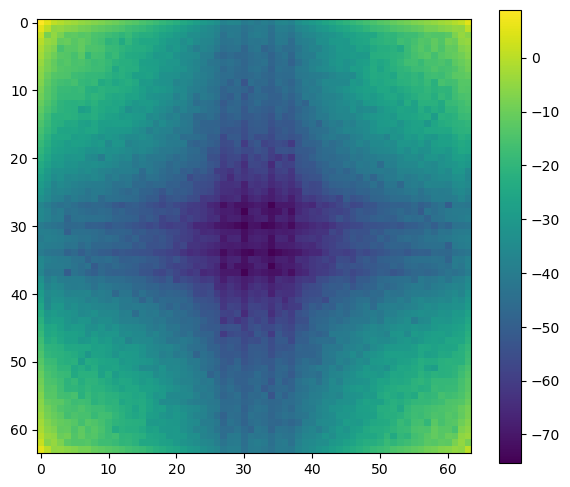

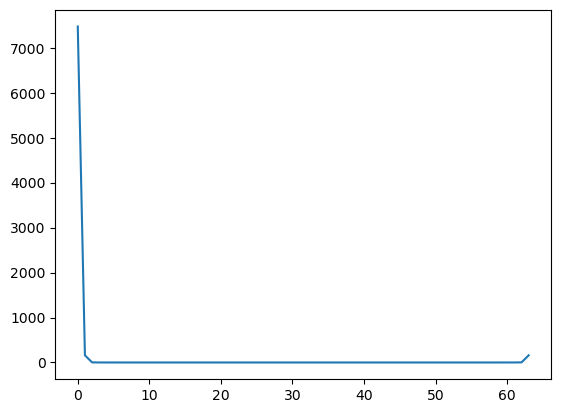

In [31]:
# plt.figure(figsize=(6,5))
# plt.imshow(G_q)
# plt.show()
# print(np.max(G_q),np.min(G_q))

# plt.figure(figsize=(6,5))
# plt.imshow(Vq)
# plt.show()
# print(np.max(Vq),np.min(Vq))


nu0 = np.clip(0.5 - 1.0*(Phi - np.median(Phi)), 0.0, 1.0).flatten()
nu = nu0.reshape((Nx, Ny))
nu_eff = gaussian_convolve(nu)
n_eff = nu_eff * D 

n_fft = fft2(n_eff)
n_q   = np.abs(n_fft * dA)**2

plt.figure(figsize=(6,5))
plt.imshow(np.log(n_q))
plt.colorbar()
plt.tight_layout()
plt.show()

plt.plot(n_q[0])
plt.show()

In [32]:
E_Coulomb = e**2/(4*np.pi*epsilon_0*epsilon_hBN*ell_B)
print(E_Coulomb)
import numpy as np
from scipy.interpolate import RegularGridInterpolator

# --- Parameters ---
# Line: y = -x + y0
y0 = 400e-9  # 400 nm in meters

# Generate a set of x positions along the line within the simulation bounds
x_vals = np.linspace(x_min, x_max, 200)
y_vals = -x_vals + y0

# Build an interpolator for Phi
phi_interp = RegularGridInterpolator((x, y), Phi, bounds_error=False, fill_value=None)
# Sample Phi along the tilted line
pts = np.column_stack((x_vals, y_vals))
phi_line = phi_interp(pts)
# Compute derivative dPhi/ds along the line (s is distance along the line)
# The line has slope -1, so ds = sqrt(2) * dx
dphi_ds = np.gradient(phi_line, x_vals) / np.sqrt(2)
# Convert to electric field along x-direction: dPhi/dx = dPhi/ds * ds/dx = dphi_ds * sqrt(2)
dPhi_dx_line = dphi_ds * np.sqrt(2)
# EV along the line
EV_line = e * dPhi_dx_line * ell_B
EV_tilted_max = np.max(np.abs(EV_line))


print(EV_tilted_max/E_Coulomb)

7.28797573810162e-21
1.75088900190356


phi=-17276.208974011148,exchange=782.3744511895057,Coulomb=6322.197398937444
phi=-17276.208974062094,exchange=782.3744511969626,Coulomb=6322.197399022097
phi=-17314.4845964431,exchange=783.5047010209595,Coulomb=6353.633697004441
phi=-17314.484596608516,exchange=783.5047010311371,Coulomb=6353.633697117319
phi=-17315.744864056836,exchange=783.5818648598843,Coulomb=6354.729655134724
phi=-17319.099932410216,exchange=783.3842966432729,Coulomb=6357.8502684495215
phi=-17318.961692544974,exchange=783.2917238655141,Coulomb=6357.77532440661
phi=-17318.910677608153,exchange=783.225929655432,Coulomb=6357.759661766124
basinhopping step 0: f -10178
phi=-17309.987926137877,exchange=782.4456163704318,Coulomb=6349.525776300816
basinhopping step 1: f -10178 trial_f -10178 accepted 1  lowest_f -10178
found new global minimum on step 1 with function value -10178
basinhopping step 2: f -10178 trial_f -10178 accepted 1  lowest_f -10178
found new global minimum on step 2 with function value -10178
phi=-17263

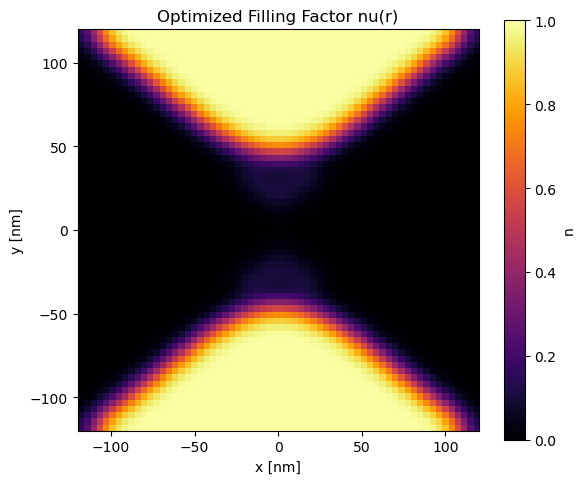

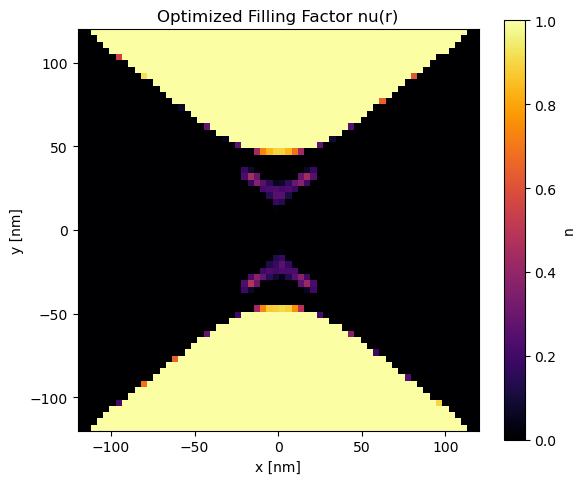

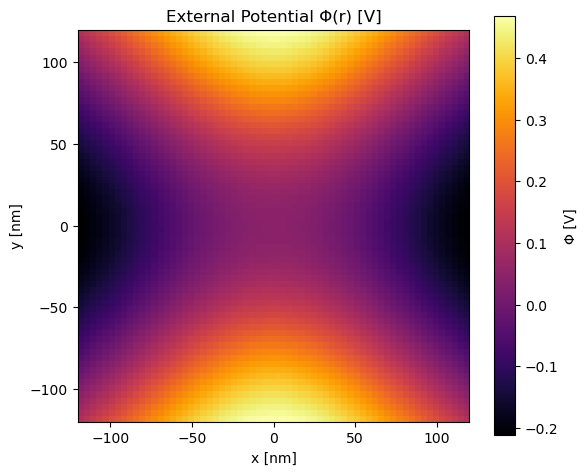

1.0


In [33]:
# =============================================================================
# Global optimization via basinhopping
# =============================================================================
bounds = [(0.0, 1.0)] * (Nx*Ny)
result = basinhopping(
    energy,
    nu0,
#     minimizer_kwargs={"method": "L-BFGS-B", "bounds": bounds},
    minimizer_kwargs = {'method': 'L-BFGS-B','options': {'maxiter': 1000,'ftol': 1e-6,'eps': 1e-8,'maxfun': 100000 },"bounds":bounds},
    niter=5,
    stepsize=0.01,
    disp=True
)

nu_opt = result.x.reshape((Nx, Ny))
nu_smoothed = gaussian_convolve(nu_opt)


# =============================================================================
# Visualization
# =============================================================================
plt.figure(figsize=(6,5))
plt.imshow(nu_smoothed, extent=[x_min*1e9, x_max*1e9, y_min*1e9, y_max*1e9], origin='lower', cmap='inferno')
plt.title("Optimized Filling Factor nu(r)")
plt.xlabel("x [nm]")
plt.ylabel("y [nm]")
plt.colorbar(label="n")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,5))
plt.imshow(nu_opt, extent=[x_min*1e9, x_max*1e9, y_min*1e9, y_max*1e9], origin='lower', cmap='inferno')
plt.title("Optimized Filling Factor nu(r)")
plt.xlabel("x [nm]")
plt.ylabel("y [nm]")
plt.colorbar(label="n")
plt.tight_layout()
plt.show()


plt.figure(figsize=(6,5))
plt.imshow(Phi, extent=[x_min*1e9, x_max*1e9, y_min*1e9, y_max*1e9], origin='lower', cmap='inferno')
plt.title("External Potential Φ(r) [V]")
plt.xlabel("x [nm]")
plt.ylabel("y [nm]")
plt.colorbar(label="Φ [V]")
plt.tight_layout()
plt.show()

print(np.max(nu_smoothed))